In [1]:
import datetime as dt
import json
import numpy as np
import pandas as pd
import re
import requests
import tweepy
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Step 1 of gathering data
# Open the Twitter Archive which is a CSV
archive = pd.read_csv("twitter-archive-enhanced.csv")
# Take a look at archive
archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [3]:
# We can already see some issues looking at the first few rows, what about if we look at the info?
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [4]:
# Step 2 of gathering data
# Use requests library to open at the URL provided in the instrucitons
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)

with open('image-predictions.tsv', mode ='wb') as file:
    file.write(response.content)

# Open the TSV file using pandas
predictions = pd.read_csv('image-predictions.tsv', sep='\t' )

In [5]:
# Take a look at the predictions file
predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [6]:
# Here we gather the twitter data
# I used the option offered to access the data without a twitter account
# First we make a dataframe to store the data in
tweets = pd.DataFrame(columns=['tweet_id', 'retweet_count', 'favorite_count'])
# Then we open the txt file and put the data in our dataframe for the project
with open('tweet_json.txt') as file:
    for line in file:
        status  = json.loads(line)
        tweet_id = status['id_str'] # ID is needed to match with our other data files
        retweet_count = status['retweet_count'] # Retweet_count is also required by this project
        favorite_count = status['favorite_count'] # Favorite_count is also required by this project
        tweets = tweets.append(pd.DataFrame([[tweet_id, retweet_count, favorite_count]],
                                        columns=['tweet_id', 'retweet_count', 'favorite_count'])) # Put data in df
tweets = tweets.reset_index(drop=True) # Organize

In [7]:
tweets.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


### Cleaning Data

In [8]:
# Create copies of data to fix
# That way we can return/fix code easily without completely restarting
archive_clean = archive.copy() # Create the archive copy
predictions_clean = predictions.copy() # Create the predictions copy
tweets_clean = tweets.copy() # Create the tweets copy
# Now we can manipulate the copies of our data in order to complete the project

### Quality Issue 1

In [9]:
archive_clean.info() # Here we can see that there are 181 unoriginal tweets that need to be removed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [10]:
# Use drop to delete all unoriginal tweets
archive_clean.drop(archive_clean[archive_clean['retweeted_status_id'].notnull()== True].index, inplace= True)
archive_clean.shape[0] # Check that 181 retweets have been deleted

2175

### Tidiness Issue 1

In [11]:
# Now we can removed several columns that we will not need to use going forward
archive_clean.drop(['retweeted_status_id', 'retweeted_status_user_id','retweeted_status_timestamp', 'in_reply_to_status_id', 'in_reply_to_user_id'], axis= 1 , inplace= True)

In [12]:
archive_clean.info() # Look at the remaining data
# We can see that there are fewer columns now, tidying up our data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2175 non-null int64
timestamp             2175 non-null object
source                2175 non-null object
text                  2175 non-null object
expanded_urls         2117 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  2175 non-null object
doggo                 2175 non-null object
floofer               2175 non-null object
pupper                2175 non-null object
puppo                 2175 non-null object
dtypes: int64(3), object(9)
memory usage: 220.9+ KB


### Quality Issue 2

In [13]:
archive_clean.head() # Earlier I noticed that the timestamp column needed to be fixed

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [14]:
archive_clean['timestamp'] = pd.to_datetime(archive_clean.timestamp) # Here we convert the full timestamp column to use datetime by pandas

In [15]:
archive_clean.head() # Now we can check how it looks

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Tidiness Issue 2

In [16]:
archive_clean.info() # Why do we have separate columns for doggo, floofer, pupper, and puppo?

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2175 non-null int64
timestamp             2175 non-null datetime64[ns]
source                2175 non-null object
text                  2175 non-null object
expanded_urls         2117 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  2175 non-null object
doggo                 2175 non-null object
floofer               2175 non-null object
pupper                2175 non-null object
puppo                 2175 non-null object
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 220.9+ KB


In [17]:
# First I create a new column called type of dog which combines doggo, floofer, pupper, and puppo columns
archive_clean["Type of Dog"] = archive_clean["doggo"] + archive_clean["floofer"] + archive_clean["pupper"] + archive_clean["puppo"]

In [18]:
archive_clean.sample(10)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,Type of Dog
114,870656317836468226,2017-06-02 15:00:16,"<a href=""http://twitter.com/download/iphone"" r...",This is Cody. He zoomed too aggressively and t...,https://www.gofundme.com/help-fix-codys-torn-a...,13,10,Cody,None,None,None,None,NoneNoneNoneNone
1234,712717840512598017,2016-03-23 19:09:09,"<a href=""http://twitter.com/download/iphone"" r...",Please don't send in any more polar bears. We ...,https://twitter.com/dog_rates/status/712717840...,10,10,None,None,None,None,None,NoneNoneNoneNone
1689,681340665377193984,2015-12-28 05:07:27,"<a href=""http://twitter.com/download/iphone"" r...",I've been told there's a slight possibility he...,NaN,5,10,None,None,None,None,None,NoneNoneNoneNone
1942,673711475735838725,2015-12-07 03:51:47,"<a href=""http://twitter.com/download/iphone"" r...",🎶 HELLO FROM THE OTHER SIIIIIIIIDE 🎶 10/10 htt...,https://twitter.com/dog_rates/status/673711475...,10,10,None,None,None,None,None,NoneNoneNoneNone
1111,733482008106668032,2016-05-20 02:18:32,"<a href=""http://twitter.com/download/iphone"" r...","""Ello this is dog how may I assist"" ...10/10 h...",https://twitter.com/dog_rates/status/733482008...,10,10,None,None,None,None,None,NoneNoneNoneNone
1262,710140971284037632,2016-03-16 16:29:35,"<a href=""http://twitter.com/download/iphone"" r...",This is Tater. His underbite is fierce af. Doe...,https://twitter.com/dog_rates/status/710140971...,8,10,Tater,None,None,None,None,NoneNoneNoneNone
466,817171292965273600,2017-01-06 00:49:53,"<a href=""http://twitter.com/download/iphone"" r...",This is Tebow. He kindly requests that you put...,https://twitter.com/dog_rates/status/817171292...,13,10,Tebow,None,None,None,None,NoneNoneNoneNone
864,762464539388485633,2016-08-08 01:44:46,"<a href=""http://twitter.com/download/iphone"" r...",This is Buddy. His father was a bear and his m...,https://twitter.com/dog_rates/status/762464539...,12,10,Buddy,None,None,None,None,NoneNoneNoneNone
202,853639147608842240,2017-04-16 16:00:07,"<a href=""http://twitter.com/download/iphone"" r...",A photographer took pictures before and after ...,https://twitter.com/dog_rates/status/853639147...,13,10,None,None,None,None,None,NoneNoneNoneNone
2295,667119796878725120,2015-11-18 23:18:48,"<a href=""http://twitter.com/download/iphone"" r...",This is Gabe. He is a southern Baklava. Gabe h...,https://twitter.com/dog_rates/status/667119796...,10,10,Gabe,None,None,None,None,NoneNoneNoneNone


In [19]:
# Now we replace the combination names with the correct single name
archive_clean['Type of Dog'].replace("NoneNoneNoneNone","None ", inplace=True) # if all none then filled with none
archive_clean['Type of Dog'].replace("doggoNoneNoneNone","doggo", inplace=True)# if doggo then filled with doggo
archive_clean['Type of Dog'].replace("NoneflooferNoneNone","floofer", inplace=True)# if floofer then filled with floofer
archive_clean['Type of Dog'].replace("NoneNonepupperNone","pupper", inplace=True)# if pupper then filled pupper
archive_clean['Type of Dog'].replace("NoneNoneNonepuppo","puppo", inplace=True)# if puppo then filled puppo
# I noticed this mistake when reviewing random samples above
archive_clean['Type of Dog'].replace("doggoNonepuppernone","doggo", inplace=True)# if doggo and pupper then filled doggo

In [20]:
archive_clean.sample(10) # So far so good, but lets double check

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,Type of Dog
1923,674082852460433408,2015-12-08 04:27:30,"<a href=""http://twitter.com/download/iphone"" r...",This is a Sagitariot Baklava mix. Loves her ne...,https://twitter.com/dog_rates/status/674082852...,11,10,a,None,None,None,None,None
1245,711732680602345472,2016-03-21 01:54:29,"<a href=""http://twitter.com/download/iphone"" r...",I want to hear the joke this dog was just told...,https://twitter.com/dog_rates/status/711732680...,10,10,None,None,None,None,None,None
1639,684177701129875456,2016-01-05 01:00:50,"<a href=""http://twitter.com/download/iphone"" r...",This is Kulet. She's very proud of the flower ...,https://twitter.com/dog_rates/status/684177701...,10,10,Kulet,None,None,None,None,None
1262,710140971284037632,2016-03-16 16:29:35,"<a href=""http://twitter.com/download/iphone"" r...",This is Tater. His underbite is fierce af. Doe...,https://twitter.com/dog_rates/status/710140971...,8,10,Tater,None,None,None,None,None
2257,667728196545200128,2015-11-20 15:36:22,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Meet Olive. He comes to spot by tree to remini...,https://twitter.com/dog_rates/status/667728196...,11,10,Olive,None,None,None,None,None
882,760290219849637889,2016-08-02 01:44:48,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",This is Rocco. He's doing his best. 13/10 some...,https://twitter.com/dog_rates/status/760290219...,13,10,Rocco,None,None,None,None,None
1456,695314793360662529,2016-02-04 18:35:39,"<a href=""http://twitter.com/download/iphone"" r...",This is Colin. He really likes green beans. It...,https://twitter.com/dog_rates/status/695314793...,10,10,Colin,None,None,None,None,None
2145,669926384437997569,2015-11-26 17:11:11,"<a href=""http://twitter.com/download/iphone"" r...",I've never seen a dog so genuinely happy about...,https://twitter.com/dog_rates/status/669926384...,12,10,None,None,None,None,None,None
1712,680494726643068929,2015-12-25 21:06:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have uncovered an entire battalion of ...,https://twitter.com/dog_rates/status/680494726...,26,10,None,None,None,None,None,None
647,793135492858580992,2016-10-31 17:00:11,"<a href=""http://twitter.com/download/iphone"" r...",Your favorite squad is looking extra h*ckin sp...,https://twitter.com/dog_rates/status/793135492...,13,10,None,None,None,None,None,None


In [21]:
print (archive_clean['Type of Dog'].unique()) # Here we check that our new column doesn't have any more mistakes
# We find that there are a couple more to fix

['None ' 'doggo' 'puppo' 'pupper' 'floofer' 'doggoNoneNonepuppo'
 'doggoflooferNoneNone' 'doggoNonepupperNone']


In [22]:
archive_clean['Type of Dog'].replace("NoneNoneNoneNone","None ", inplace=True) # if all none then filled with none
archive_clean['Type of Dog'].replace("doggoNoneNoneNone","doggo", inplace=True)# if doggo then filled with doggo
archive_clean['Type of Dog'].replace("NoneflooferNoneNone","floofer", inplace=True)# if floofer then filled with floofer
archive_clean['Type of Dog'].replace("NoneNonepupperNone","pupper", inplace=True)# if pupper then filled pupper
archive_clean['Type of Dog'].replace("NoneNoneNonepuppo","puppo", inplace=True)# if puppo then filled puppo
#Saw this one in random sample
archive_clean['Type of Dog'].replace("doggoNonepuppernone","doggo", inplace=True)# if doggo and pupper then filled doggo
#Add in more found in unique list
#In each case, we select the leftmost option
archive_clean['Type of Dog'].replace("doggoNoneNonepuppo","doggo", inplace=True)# 
archive_clean['Type of Dog'].replace("doggoflooferNoneNone","doggo", inplace=True)# 
archive_clean['Type of Dog'].replace("doggoNonepupperNone","doggo", inplace=True)

In [23]:
print (archive_clean['Type of Dog'].unique())
# We now have a single column that shows our type of dog instead of several separate columns

['None ' 'doggo' 'puppo' 'pupper' 'floofer']


### Quality Issue 3

In [24]:
# Above I noticed that the source column could be fixed
archive_clean['source'] = archive_clean['source'].apply(lambda x: re.findall(r'>(.*)<', x)[0])
# Now we can easily see the source for each tweet

In [25]:
archive_clean.head() # Lets check our work

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,Type of Dog
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,None


### Quality Issue 4

In [26]:

# Search each to see if any male or female pronouns are used, then create list
male = ['He', 'he', 'him', 'his', "he's", 'himself']
female = ['She', 'she', 'her', 'hers', 'herself', "she's"]
dog_gender = []
for text in archive_clean['text']:
    # Check if male
    if any(map(lambda v:v in male, text.split())):
        dog_gender.append('male')
    # Check if female
    elif any(map(lambda v:v in female, text.split())):
        dog_gender.append('female')
    # If gender can't be identified
    else:
        dog_gender.append('NaN')
# Test
len(dog_gender)
# Create new column with results
archive_clean['dog_gender'] = dog_gender

In [27]:
print("dog_gender count \n", archive_clean.dog_gender.value_counts()) # Check our results

dog_gender count 
 NaN       1274
male       668
female     233
Name: dog_gender, dtype: int64


In [28]:
# Instead of NaN, lets change it to none type
archive_clean.loc[archive_clean['dog_gender'] == 'NaN', 'dog_gender'] = None

In [29]:
archive_clean.head() # Lets check our work

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,Type of Dog,dog_gender
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,None,female
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,None,male
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,None,female
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,None,male


### Quality Issue 5

In [30]:
archive_clean.info() # Check int type for tweet_id

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id              2175 non-null int64
timestamp             2175 non-null datetime64[ns]
source                2175 non-null object
text                  2175 non-null object
expanded_urls         2117 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  2175 non-null object
doggo                 2175 non-null object
floofer               2175 non-null object
pupper                2175 non-null object
puppo                 2175 non-null object
Type of Dog           2175 non-null object
dog_gender            901 non-null object
dtypes: datetime64[ns](1), int64(3), object(10)
memory usage: 254.9+ KB


In [31]:
tweets.info() # tweet_id needs to be converted to int type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null object
retweet_count     2354 non-null object
favorite_count    2354 non-null object
dtypes: object(3)
memory usage: 55.2+ KB


In [32]:
tweets_clean['tweet_id'] = tweets_clean['tweet_id'].astype(int) # Change to into type

In [33]:
tweets_clean.info() # Check that int type was correctly changed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null int64
retweet_count     2354 non-null object
favorite_count    2354 non-null object
dtypes: int64(1), object(2)
memory usage: 55.2+ KB


In [34]:
predictions_clean.info() # Check int type for tweet_id

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


### Quality Issue 6

In [35]:
# We also need to fix rating numerator and denominator types to float
archive_clean[['rating_numerator', 'rating_denominator']] = archive_clean[['rating_numerator','rating_denominator']].astype(float)
archive_clean.info() # Check work

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id              2175 non-null int64
timestamp             2175 non-null datetime64[ns]
source                2175 non-null object
text                  2175 non-null object
expanded_urls         2117 non-null object
rating_numerator      2175 non-null float64
rating_denominator    2175 non-null float64
name                  2175 non-null object
doggo                 2175 non-null object
floofer               2175 non-null object
pupper                2175 non-null object
puppo                 2175 non-null object
Type of Dog           2175 non-null object
dog_gender            901 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(10)
memory usage: 254.9+ KB


### Quality Issue 7

In [36]:
# Let's check tweets that have a denominator that is not equal to 10
with pd.option_context('max_colwidth', 200):
    display(archive_clean[archive_clean['rating_denominator'] != 10][['tweet_id','text','rating_numerator','rating_denominator']])

,tweet_id,text,rating_numerator,rating_denominator
313,835246439529840640,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960.0,0.0
342,832088576586297345,@docmisterio account started on 11/15/15,11.0,15.0
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84.0,70.0
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24.0,7.0
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165.0,150.0
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9.0,11.0
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204.0,170.0
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4.0,20.0
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50.0,50.0
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99.0,90.0


In [37]:
# While some of them were correct, a few need to be fixed
# Below we fix them manually
archive_clean.loc[(archive_clean.tweet_id == 740373189193256964), 'rating_numerator'] = 14 # This tweet read a date as a rating
archive_clean.loc[(archive_clean.tweet_id == 740373189193256964), 'rating_denominator'] = 10

archive_clean.loc[(archive_clean.tweet_id == 682962037429899265), 'rating_numerator'] = 10 # This tweet mentioned the store 7/11
archive_clean.loc[(archive_clean.tweet_id == 682962037429899265), 'rating_denominator'] = 10

archive_clean.loc[(archive_clean.tweet_id == 666287406224695296), 'rating_numerator'] = 9 # This tweet mentioned a half of a leg
archive_clean.loc[(archive_clean.tweet_id == 666287406224695296), 'rating_denominator'] = 10

archive_clean.loc[(archive_clean.tweet_id == 722974582966214656), 'rating_numerator'] = 13 # This tweet read a date as a rating
archive_clean.loc[(archive_clean.tweet_id == 722974582966214656), 'rating_denominator'] = 10

archive_clean.loc[(archive_clean.tweet_id == 716439118184652801), 'rating_numerator'] = 13.5 # This tweet is referring to a coin toss
archive_clean.loc[(archive_clean.tweet_id == 716439118184652801), 'rating_denominator'] = 10

# These are tweets that we can see do not include a rating, so we simply delete them
archive_clean = archive_clean[archive_clean['tweet_id'] != 832088576586297345]
archive_clean = archive_clean[archive_clean['tweet_id'] != 810984652412424192]
archive_clean = archive_clean[archive_clean['tweet_id'] != 682808988178739200]
archive_clean = archive_clean[archive_clean['tweet_id'] != 835246439529840640]
archive_clean = archive_clean[archive_clean['tweet_id'] != 686035780142297088]

# Now we can check our work by running the same check as above
with pd.option_context('max_colwidth', 200):
    display(archive_clean[archive_clean['rating_denominator'] != 10][['tweet_id',
                                                                                      'text',
                                                                                      'rating_numerator',
                                                                                      'rating_denominator']])

,tweet_id,text,rating_numerator,rating_denominator
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84.0,70.0
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165.0,150.0
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204.0,170.0
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99.0,90.0
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80.0,80.0
1274,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45.0,50.0
1351,704054845121142784,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,60.0,50.0
1433,697463031882764288,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,44.0,40.0
1634,684225744407494656,"Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3",143.0,130.0
1635,684222868335505415,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,121.0,110.0


### Quality Issue 8

In [38]:
predictions_clean.head() # We can create a new column to track first correct prediction and a column for confidence levels

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [39]:
# The lists to use
dog_type = []
confidence_list = []
# Find first correct prediction and update confidence
def image(predictions_clean):
    if predictions_clean['p1_dog'] == True: # check p1
        dog_type.append(predictions_clean['p1'])
        confidence_list.append(predictions_clean['p1_conf'])
    elif predictions_clean['p2_dog'] == True: # check p2
        dog_type.append(predictions_clean['p2'])
        confidence_list.append(predictions_clean['p2_conf'])
    elif predictions_clean['p3_dog'] == True: # check p3
        dog_type.append(predictions_clean['p3'])
        confidence_list.append(predictions_clean['p3_conf'])
    else:
        dog_type.append('Error') # if no prediction is correct
        confidence_list.append('Error')     
predictions_clean.apply(image, axis=1)
# Store our lists in columns
predictions_clean['dog_type'] = dog_type
predictions_clean['confidence_list'] = confidence_list

In [40]:
# Now we can remove rows that do not have the correct predictions
predictions_clean = predictions_clean[predictions_clean['dog_type'] != 'Error']
# Check progress
predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 0 to 2073
Data columns (total 14 columns):
tweet_id           1751 non-null int64
jpg_url            1751 non-null object
img_num            1751 non-null int64
p1                 1751 non-null object
p1_conf            1751 non-null float64
p1_dog             1751 non-null bool
p2                 1751 non-null object
p2_conf            1751 non-null float64
p2_dog             1751 non-null bool
p3                 1751 non-null object
p3_conf            1751 non-null float64
p3_dog             1751 non-null bool
dog_type           1751 non-null object
confidence_list    1751 non-null object
dtypes: bool(3), float64(3), int64(2), object(6)
memory usage: 169.3+ KB


In [41]:
predictions_clean.head() # Check work

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_type,confidence_list
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,Welsh_springer_spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,German_shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,Rhodesian_ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,miniature_pinscher,0.560311


### Tidiness 3

In [42]:
# Let's go ahead and merge our 3 files together
# First we merge archive and predictions
merged = pd.merge(archive_clean, 
                      predictions_clean, 
                      how = 'left', on = ['tweet_id'])

# Include pictures
merged = merged[merged['jpg_url'].notnull()]

# Check progress
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1685 entries, 1 to 2169
Data columns (total 27 columns):
tweet_id              1685 non-null int64
timestamp             1685 non-null datetime64[ns]
source                1685 non-null object
text                  1685 non-null object
expanded_urls         1685 non-null object
rating_numerator      1685 non-null float64
rating_denominator    1685 non-null float64
name                  1685 non-null object
doggo                 1685 non-null object
floofer               1685 non-null object
pupper                1685 non-null object
puppo                 1685 non-null object
Type of Dog           1685 non-null object
dog_gender            756 non-null object
jpg_url               1685 non-null object
img_num               1685 non-null float64
p1                    1685 non-null object
p1_conf               1685 non-null float64
p1_dog                1685 non-null object
p2                    1685 non-null object
p2_conf               1

In [43]:
# Now we add in our tweets
merged = pd.merge(merged, tweets_clean, 
                      how = 'left', on = ['tweet_id'])

# Check progress
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1685 entries, 0 to 1684
Data columns (total 29 columns):
tweet_id              1685 non-null int64
timestamp             1685 non-null datetime64[ns]
source                1685 non-null object
text                  1685 non-null object
expanded_urls         1685 non-null object
rating_numerator      1685 non-null float64
rating_denominator    1685 non-null float64
name                  1685 non-null object
doggo                 1685 non-null object
floofer               1685 non-null object
pupper                1685 non-null object
puppo                 1685 non-null object
Type of Dog           1685 non-null object
dog_gender            756 non-null object
jpg_url               1685 non-null object
img_num               1685 non-null float64
p1                    1685 non-null object
p1_conf               1685 non-null float64
p1_dog                1685 non-null object
p2                    1685 non-null object
p2_conf               1

In [44]:
merged.head() # Check our work

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_type,confidence_list,retweet_count,favorite_count
0,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,None,None,...,Pekinese,0.090647,True,papillon,0.068957,True,Chihuahua,0.323581,6514,33819
1,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,None,None,...,malamute,0.078253,True,kelpie,0.031379,True,Chihuahua,0.716012,4328,25461
2,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,None,None,...,Labrador_retriever,0.168086,True,spatula,0.040836,False,Labrador_retriever,0.168086,8964,42908
3,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,None,None,...,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,basset,0.555712,9774,41048
4,891087950875897856,2017-07-29 00:08:17,Twitter for iPhone,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13.0,10.0,None,None,None,...,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False,Chesapeake_Bay_retriever,0.425595,3261,20562


### Saving to Dataframe

In [45]:
#Store our merged data DataFrame into a CSV file
merged.to_csv('twitter_archive_master.csv', 
                 index=False, encoding = 'utf-8')

### Insight One

In [46]:
merged['dog_type'].value_counts() # Let's see how common different kinds of dogs are
# The golden retriever and labrador retriever dogs are the most common, with the golden retriever beating out the labrador by 49
# The difference between the golden retriever appears to be much greater than the difference between any other 
# two dogs that are next to each other in terms of how common they appear
# There are eight dogs tied for last place in this data set in terms of how common they are

golden_retriever                  157
Labrador_retriever                108
Pembroke                           95
Chihuahua                          91
pug                                62
toy_poodle                         51
chow                               48
Pomeranian                         42
Samoyed                            42
malamute                           33
Chesapeake_Bay_retriever           31
French_bulldog                     31
cocker_spaniel                     30
miniature_pinscher                 25
Eskimo_dog                         22
Staffordshire_bullterrier          21
Cardigan                           21
German_shepherd                    21
Siberian_husky                     20
Shih-Tzu                           20
beagle                             20
Maltese_dog                        19
Shetland_sheepdog                  19
Rottweiler                         19
kuvasz                             18
Lakeland_terrier                   18
Italian_grey

### Insight Two and Visualization One

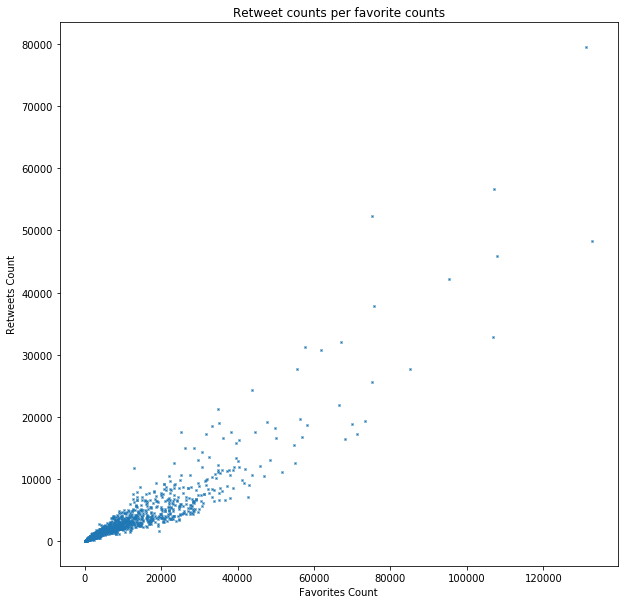

In [47]:
# Let's see if retweets and favorites increase together
plt.figure(figsize = (10, 10))
plt.plot(merged.favorite_count, merged.retweet_count, marker='x', linestyle='', ms=2 )
plt.title('Retweet counts per favorite counts')
plt.xlabel('Favorites Count')
plt.ylabel('Retweets Count')
plt.show()
# Favorites and retweets appear to increase together
# The curve might be geometric, suggesting that retweets increase faster as favorites increase
# This could be an area for further investigation

### Insight Three

In [48]:
merged.describe(include='all') # Let's look at some general information about each column

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_type,confidence_list,retweet_count,favorite_count
count,1.685000e+03,1685,1685,1685,1685,1685.000000,1685.000000,1685,1685,1685,...,1685,1685.000000,1685,1685,1.685000e+03,1685,1685,1685.000000,1685.0,1685.0
unique,NaN,1685,3,1685,1685,NaN,NaN,852,2,2,...,229,NaN,2,234,NaN,2,113,1682.000000,1400.0,1585.0
top,NaN,2015-12-08 16:21:41,Twitter for iPhone,Yea I can't handle the cuteness anymore. Curls...,https://twitter.com/dog_rates/status/802572683...,NaN,NaN,None,None,None,...,Labrador_retriever,NaN,True,Labrador_retriever,NaN,True,golden_retriever,0.873233,1972.0,610.0
freq,NaN,1,1654,1,1,NaN,NaN,419,1621,1677,...,96,NaN,1494,75,NaN,1445,157,2.000000,4.0,3.0
first,NaN,2015-11-15 22:32:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2017-08-01 00:17:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,7.392284e+17,NaN,NaN,NaN,NaN,11.459644,10.510386,NaN,NaN,NaN,...,NaN,0.137207,NaN,NaN,6.137956e-02,NaN,NaN,NaN,NaN,NaN
std,6.800380e+16,NaN,NaN,NaN,NaN,8.042577,6.873521,NaN,NaN,NaN,...,NaN,0.101252,NaN,NaN,5.188869e-02,NaN,NaN,NaN,NaN,NaN
min,6.660209e+17,NaN,NaN,NaN,NaN,0.000000,10.000000,NaN,NaN,NaN,...,NaN,0.000010,NaN,NaN,2.160900e-07,NaN,NaN,NaN,NaN,NaN
25%,6.773346e+17,NaN,NaN,NaN,NaN,10.000000,10.000000,NaN,NaN,NaN,...,NaN,0.054950,NaN,NaN,1.596500e-02,NaN,NaN,NaN,NaN,NaN


In [49]:
# It appears that, on average, numerators tend to have a greater value than denominators.
# This suggests that ratings tend to be greater than the maximum value
# This may suggest that people in this sample really liked the dogs they tweeted about